# Analyze neutralization data
This Python Jupyter notebook analyzes the neutralization data.

Import Python modules.
We use [neutcurve](https://jbloomlab.github.io/neutcurve/) to plot the neutralization curves:

In [1]:
import warnings

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import neutcurve
from neutcurve.colorschemes import CBPALETTE
from neutcurve.colorschemes import CBMARKERS

import pandas as pd

print(f"Using `neutcurve` version {neutcurve.__version__}")

Using `neutcurve` version 0.5.0


Specify input / output files:

In [2]:
# input files
fracinfect_file = 'results/fracinfect.csv'

# output files
all_replicate_curves = 'results/all_neut_replicates.pdf'
all_neut_by_sera_curves = 'results/all_neut_by_sera.pdf'
all_fit_params = 'results/all_fit_params.csv'
all_neut_titers = 'results/all_neut_titers.csv'

Read in the neutralization data:

In [3]:
print(f"Reading neutralization data from {fracinfect_file}")
fracinfect = pd.read_csv(fracinfect_file)

# Input data restarts replicate numbers for each new date. Instead label replicates as:
#  - replicate_on_date: number of the replicate on that specific date
#  - replicate_with_date: number of replicate on that date suffixed by date
#  - replicate_all_dates: number replicates sequentially across all dates
fracinfect = (
    fracinfect
    .assign(replicate_with_date=lambda x: x['replicate'].astype(str) +
                                          ' (' + x['date'] + ')')
    .rename(columns={'replicate': 'replicate_on_date'})
    )
fracinfect = (
    fracinfect
    .merge(fracinfect
           .sort_values('date')
           [['serum', 'virus', 'replicate_with_date']]
           .drop_duplicates()
           .assign(replicate_all_dates=lambda x: x.groupby(['serum', 'virus'])
                                                  ['replicate_with_date']
                                                  .transform('cumcount') + 1
                   ),
            how='left', on=['serum', 'virus', 'replicate_with_date'], validate='many_to_one',
            )
    )

# make sure unique reading for each virus / serum / replicate / date
assert len(fracinfect) == len(fracinfect.groupby(['serum',
                                                  'virus',
                                                  'replicate_all_dates',
                                                  'concentration',
                                                  ]))

# show first few lines of data frame
display(HTML(fracinfect.head().to_html()))

Reading neutralization data from results/fracinfect.csv


,serum,virus,replicate_on_date,concentration,fraction infectivity,date,replicate_with_date,replicate_all_dates
0,FH007TR,229E-1992,1,0.100000,0.4530,2020-10-22,1 (2020-10-22),2
1,FH007TR,229E-1992,1,0.033330,0.7756,2020-10-22,1 (2020-10-22),2
2,FH007TR,229E-1992,1,0.011110,0.8930,2020-10-22,1 (2020-10-22),2
3,FH007TR,229E-1992,1,0.003704,0.9029,2020-10-22,1 (2020-10-22),2
4,FH007TR,229E-1992,1,0.001235,1.2490,2020-10-22,1 (2020-10-22),2


Use [neutcurve](https://jbloomlab.github.io/neutcurve/) to fit neutralization curves to all of the data:

In [4]:
fits = neutcurve.curvefits.CurveFits(
            data=fracinfect,
            replicate_col='replicate_all_dates',
            fixbottom=0,
            fixtop=1,
            )

Plot all curves for all replicates of all virus / serum combinations:

Saving plot to results/all_neut_replicates.pdf



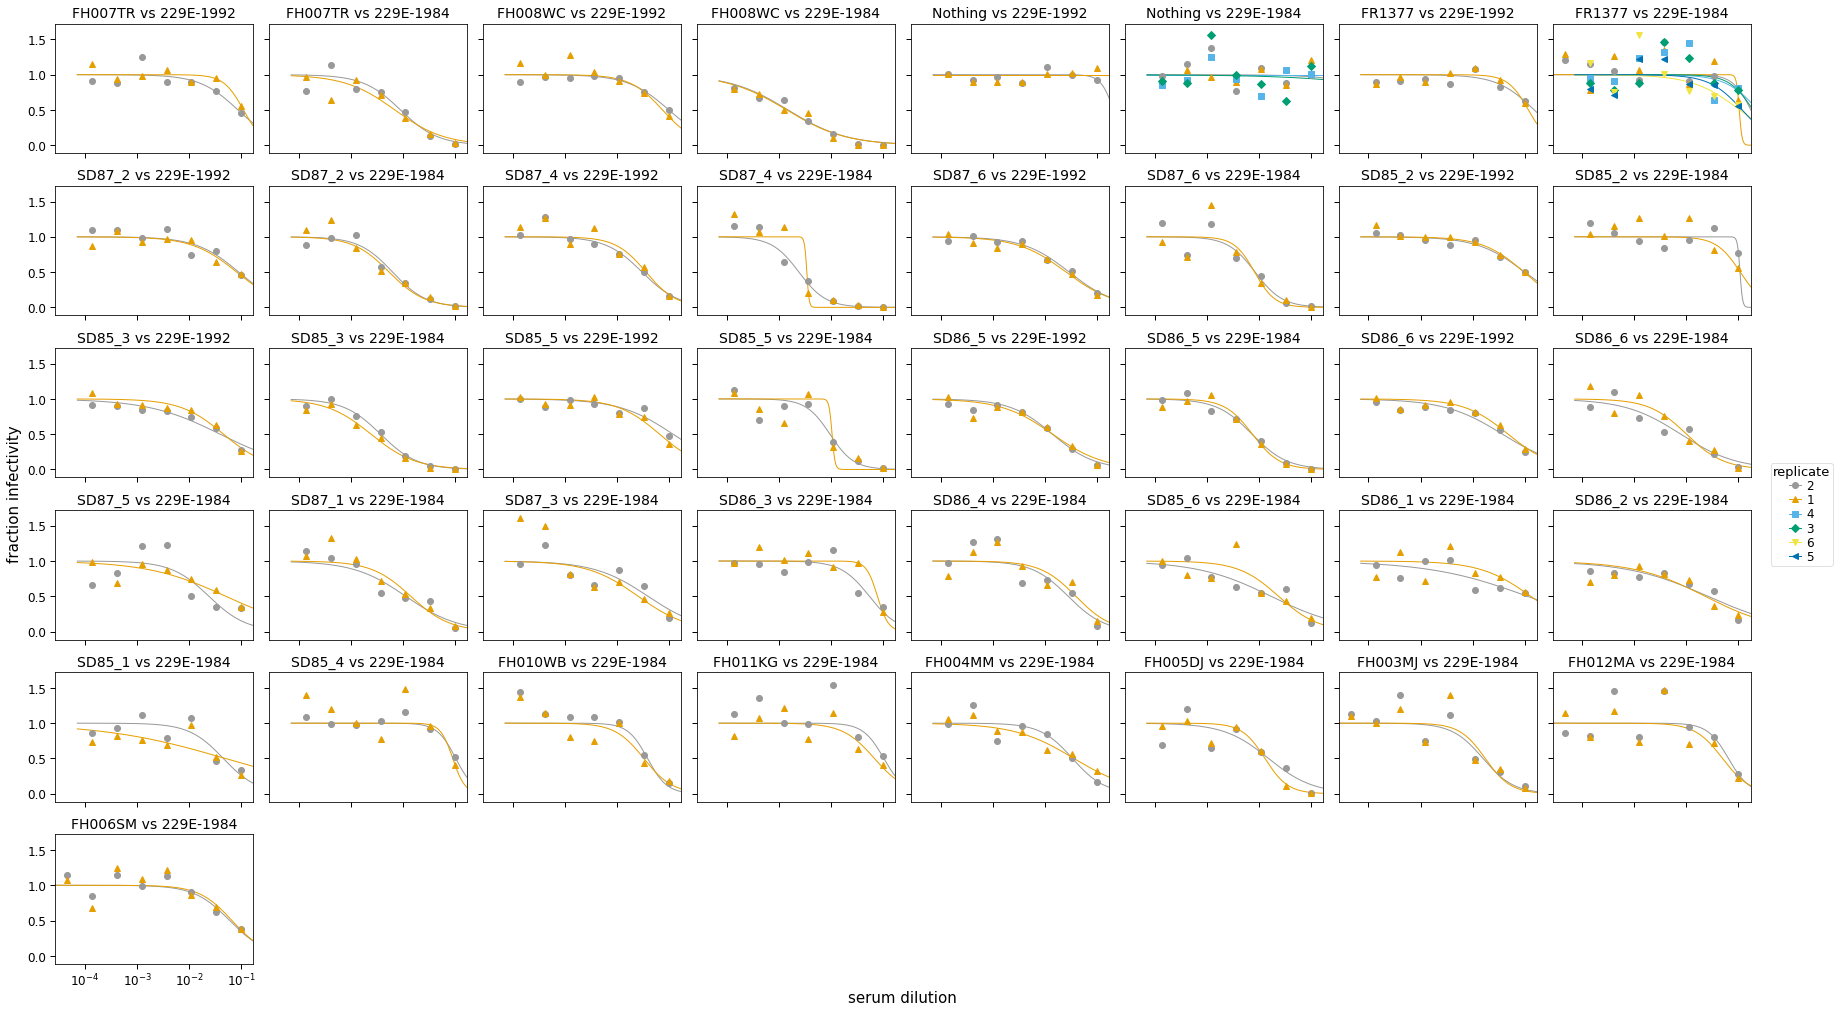

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # ignore fitting warnings
    fig, _ = fits.plotReplicates(ncol=8,
                                 legendtitle='replicate',
                                 xlabel='serum dilution',
                                 )
    
print(f"Saving plot to {all_replicate_curves}\n")
fig.savefig(all_replicate_curves)
fig.tight_layout()
display(fig)
plt.close(fig)

Make a plot showing:

/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/neutcurve/hillcurve.py:689: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m)**s)


Saving plot to results/all_neut_by_sera.pdf



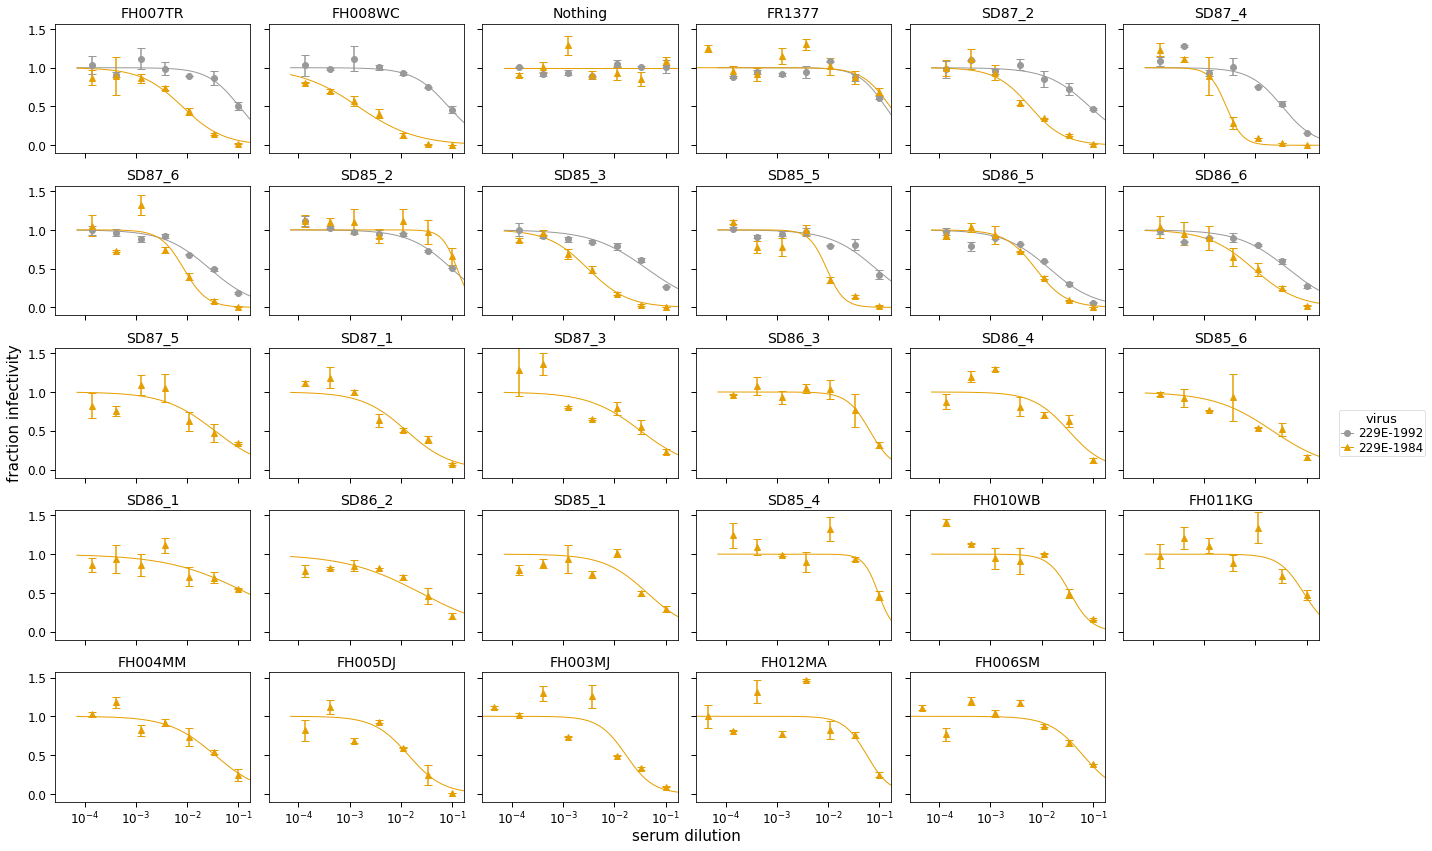

In [6]:
fig, _ = fits.plotSera(xlabel='serum dilution',
                       ncol=6,
                       legendtitle='virus')

print(f"Saving plot to {all_neut_by_sera_curves}\n")
fig.savefig(all_neut_by_sera_curves)
fig.tight_layout()
display(fig)
plt.close(fig)

Write all of the fit parameters to a file:

In [7]:
print(f"Writing all fit parameters to {all_fit_params}; first few lines also printed below:")

display(HTML(fits.fitParams().head().to_html()))

fits.fitParams().to_csv(all_fit_params, index=False)

Writing all fit parameters to results/all_fit_params.csv; first few lines also printed below:


,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,slope,top,bottom
0,FH007TR,229E-1992,average,2,0.100000,lower,>0.1,0.103966,1.414215,1,0
1,FH007TR,229E-1984,average,2,0.008009,interpolated,0.00801,0.008009,1.074526,1,0
2,FH008WC,229E-1992,average,2,0.084957,interpolated,0.085,0.084957,1.268635,1,0
3,FH008WC,229E-1984,average,2,0.001461,interpolated,0.00146,0.001461,0.765615,1,0
4,Nothing,229E-1992,average,2,0.100000,lower,>0.1,1.376719,8.518559,1,0


Get neutralization titers:

In [8]:
neut_titers = (
    fits.fitParams()
    .assign(neut_titer=lambda x: 1 / x['ic50'])
    .assign(is_upper_bound=lambda x: x['ic50_bound'].map({'lower': True,
                                                          'interpolated': False}))
    [['serum', 'virus', 'neut_titer', 'is_upper_bound']]
    )
display(HTML(neut_titers.to_html(float_format='%.1f')))

print(f"Writing to {all_neut_titers}")
neut_titers.to_csv(all_neut_titers, index=False, float_format='%.1f')

,serum,virus,neut_titer,is_upper_bound
0,FH007TR,229E-1992,10.0,True
1,FH007TR,229E-1984,124.9,False
2,FH008WC,229E-1992,11.8,False
3,FH008WC,229E-1984,684.4,False
4,Nothing,229E-1992,10.0,True
5,Nothing,229E-1984,10.0,True
6,FR1377,229E-1992,10.0,True
7,FR1377,229E-1984,10.0,True
8,SD87_2,229E-1992,11.7,False
9,SD87_2,229E-1984,170.5,False


Writing to results/all_neut_titers.csv
